In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from six import StringIO
from IPython.display import Image
import pydotplus
import graphviz

# Problem 2: CART-RF-ANN
----------

## Problem Statement:
An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

## Data Dictionary for Market Segmentation:
1. Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration in days)
7. Destination of the tour (Destination)
8. Amount of sales of tour insurance policies (Sales)
9. The commission received for tour insurance firm (Commission)
10. Age of insured (Age)

# ---------------------------------------------------------------------------------------------

### Question 1

Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.

In [2]:
# Importing the data from CSV
claim_df = pd.read_csv('insurance_part2_data-2.csv')

In [3]:
# Checking if data imported correctly
claim_df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [4]:
# Checking the shape of dataframe
claim_df.shape

(3000, 10)

In [5]:
# Columns in the dataframe
claim_df.columns

Index(['Age', 'Agency_Code', 'Type', 'Claimed', 'Commision', 'Channel',
       'Duration', 'Sales', 'Product Name', 'Destination'],
      dtype='object')

In [6]:
# Getting the info for the data
claim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [7]:
# Checking for any missing values
claim_df.isna().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [8]:
# 5 number summary of the integer and float data types
claim_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,3000.0,38.091000,10.463518,8.0,32.0,36.00,42.000,84.00
Commision,3000.0,14.529203,25.481455,0.0,0.0,4.63,17.235,210.21
Duration,3000.0,70.001333,134.053313,-1.0,11.0,26.50,63.000,4580.00
Sales,3000.0,60.249913,70.733954,0.0,20.0,33.00,69.000,539.00


In [9]:
# Summary of the categorical variables
claim_df.describe(include='object').T

,count,unique,top,freq
Agency_Code,3000,4,EPX,1365
Type,3000,2,Travel Agency,1837
Claimed,3000,2,No,2076
Channel,3000,2,Online,2954
Product Name,3000,5,Customised Plan,1136
Destination,3000,3,ASIA,2465


From the 5 number summary it is noted that there are negative values in Duration which is an invalid entry. We will see the numer of rows that has negative duration and decide if we need to impute or drop.

In [10]:
# Arange in ascending order and view the head
claim_df['Duration'].sort_values().head()

1508   -1
1746    0
2628    0
424     1
1430    1
Name: Duration, dtype: int64

There is only one negative value. 0 can be taken as Not traveled as well. Since it is only one row we will drop this row.

In [11]:
# Droping that one row which has a negative Duration of travel.
claim_df = claim_df[claim_df['Duration']>=0]

Form the five number summary the highest value in duration is 4580 i.e. more than 10 years. This is practically impossible and so we can remove this from the data as well.

In [12]:
# Ordering the data to check if there are more datas in the duration column that are abnormally large
claim_df['Duration'].sort_values(ascending=False).head()

2845    4580
2914     466
2260     434
1398     431
873      428
Name: Duration, dtype: int64

In [13]:
# Droping the row with 4580 days as Duration
claim_df.drop([2845], axis=0, inplace=True)

In [14]:
# 5 Number summary to check if the data after the above treatment is fine
claim_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2998.0,38.092061,10.462712,8.0,32.0,36.00,42.000,84.00
Commision,2998.0,14.536765,25.488146,0.0,0.0,4.63,17.245,210.21
Duration,2998.0,68.520680,105.790319,0.0,11.0,26.50,63.000,466.00
Sales,2998.0,60.283996,70.744865,0.0,20.0,33.00,69.000,539.00


In [15]:
# Checking for duplicates
claim_df[claim_df.duplicated()]

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,C2B,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
329,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
407,36,EPX,Travel Agency,No,0.0,Online,11,19.0,Cancellation Plan,ASIA
411,35,EPX,Travel Agency,No,0.0,Online,2,20.0,Customised Plan,ASIA
422,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
...,...,...,...,...,...,...,...,...,...,...
2940,36,EPX,Travel Agency,No,0.0,Online,8,10.0,Cancellation Plan,ASIA
2947,36,EPX,Travel Agency,No,0.0,Online,10,28.0,Customised Plan,ASIA
2952,36,EPX,Travel Agency,No,0.0,Online,2,10.0,Cancellation Plan,ASIA
2962,36,EPX,Travel Agency,No,0.0,Online,4,20.0,Customised Plan,ASIA


We have 286 duplicate rows (repetitive entries). Though these values will assign a weightage to the repeated values, since we don’t have a unique column like Customer name or Customer ID etc we cannot conclude if these are erroneously duplicated. So we will proceed retaining these values.

-------
### Univariate Analysis

In [16]:
# Varible assignement to make things easy for univariate analysis
continuous = ['Age', 'Commision', 'Duration', 'Sales']
categorical = ['Agency_Code', 'Type', 'Claimed', 'Channel', 'Product Name', 'Destination']

In [17]:
# User defined function to get upper and lower whisker values for each column
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

Age


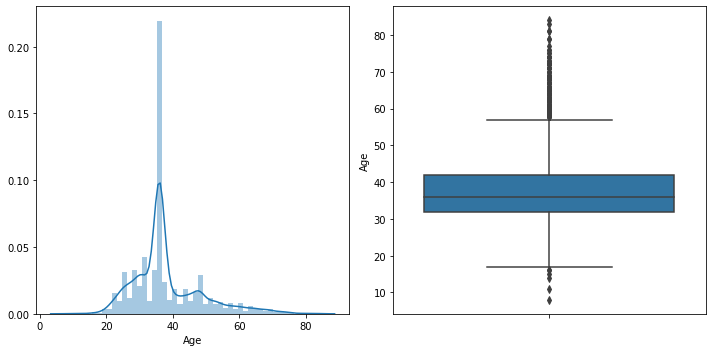

Age is Positive or Right skewed.
The number of outliers in Age is 204 (6.80% of total data)

---------------------------------------------------------------------------------------
Commision


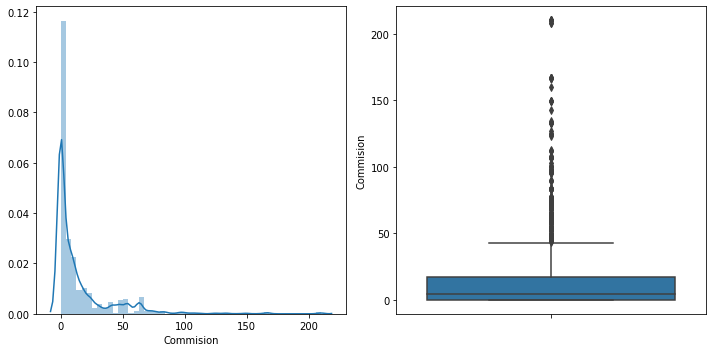

Commision is Positive or Right skewed.
The number of outliers in Commision is 362 (12.07% of total data)

---------------------------------------------------------------------------------------
Duration


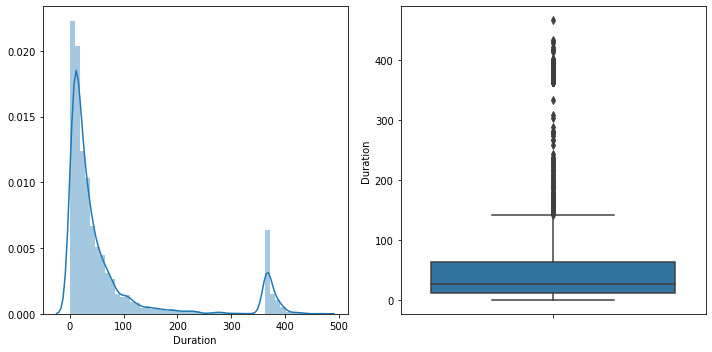

Duration is Positive or Right skewed.
The number of outliers in Duration is 381 (12.71% of total data)

---------------------------------------------------------------------------------------
Sales


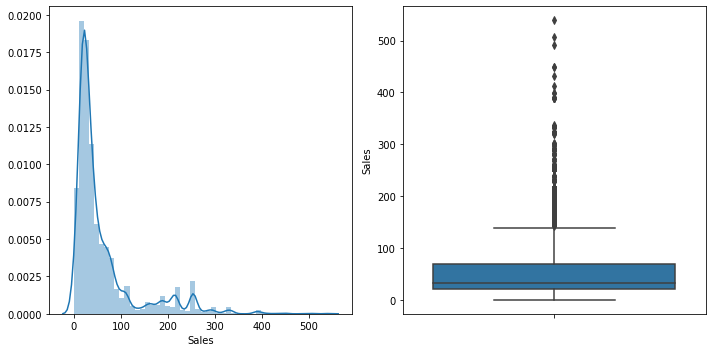

Sales is Positive or Right skewed.
The number of outliers in Sales is 353 (11.77% of total data)

---------------------------------------------------------------------------------------


In [18]:
# Univariate analysis
data = claim_df.copy()
for i in continuous:
    print('\033[1m'+i+'\033[0m')
    fig, axes = plt.subplots(ncols=2)
    fig.set_size_inches(10,5)
    sns.distplot(data[i] , ax=axes[:][0], label=i)
    sns.boxplot(data[i] , orient = "v" , ax=axes[:][1])
    plt.tight_layout()
    plt.show()
    skew = data[i].skew()
    if(skew > 0):
        print('%s is Positive or Right skewed.' %(i))
    elif(skew < 0):
        print('%s is Negative or Left skewed.' %(i))
    else:
        print('%s is not skewed.' %(i))
    lratio,uratio=remove_outlier(data[i])
    print('The number of outliers in %s is %d (%0.2f%% of total data)\n'% (i,((data[i]>uratio) | (data[i]<lratio)).sum(),(((data[i]>uratio) | (data[i]<lratio)).sum()*100/data[i].count())))
    print('---------------------------------------------------------------------------------------')



Agency_Code

The number of unique entries in the column Agency_Code : 4

The entry with the highest frequency in Agency_Code : EPX



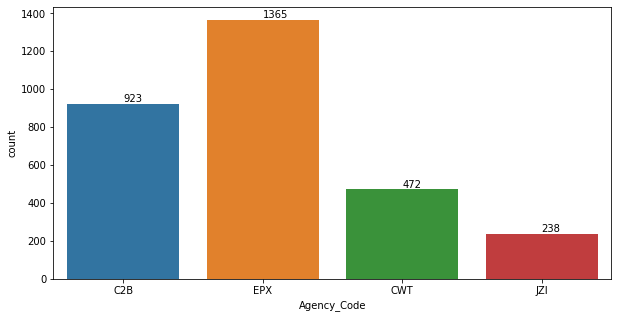

Percentage share:

EPX    45.530354
C2B    30.787191
CWT    15.743829
JZI     7.938626
Name: Agency_Code, dtype: float64
---------------------------------------------------------------------------------------


Type

The number of unique entries in the column Type : 2

The entry with the highest frequency in Type : Travel Agency



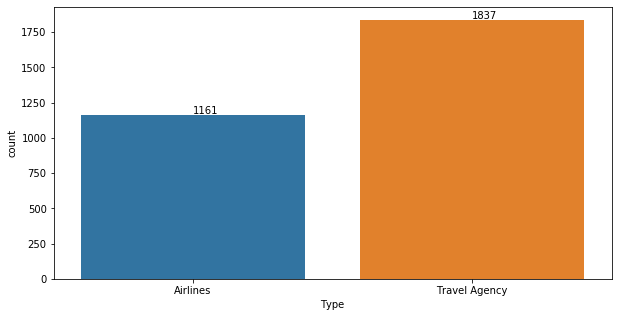

Percentage share:

Travel Agency    61.274183
Airlines         38.725817
Name: Type, dtype: float64
---------------------------------------------------------------------------------------


Claimed

The number of unique entries in the column Claimed : 2

The entry with the highest frequency in Claimed : No



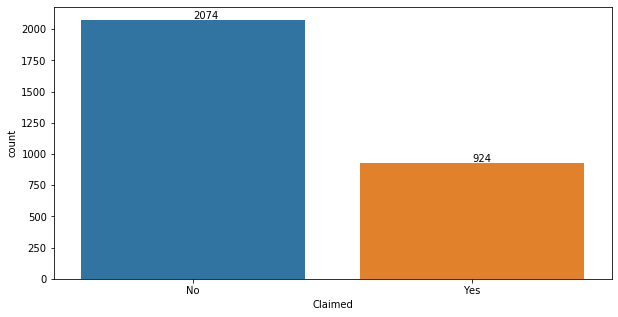

Percentage share:

No     69.179453
Yes    30.820547
Name: Claimed, dtype: float64
---------------------------------------------------------------------------------------


Channel

The number of unique entries in the column Channel : 2

The entry with the highest frequency in Channel : Online



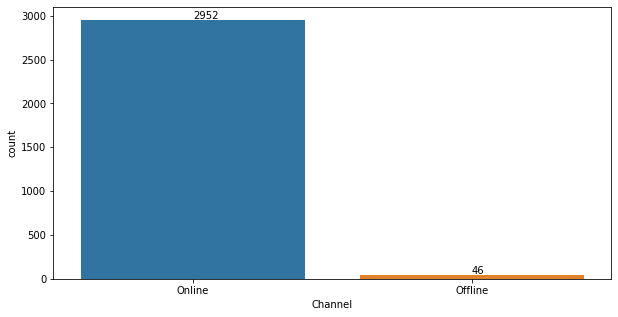

Percentage share:

Online     98.465644
Offline     1.534356
Name: Channel, dtype: float64
---------------------------------------------------------------------------------------


Product Name

The number of unique entries in the column Product Name : 5

The entry with the highest frequency in Product Name : Customised Plan



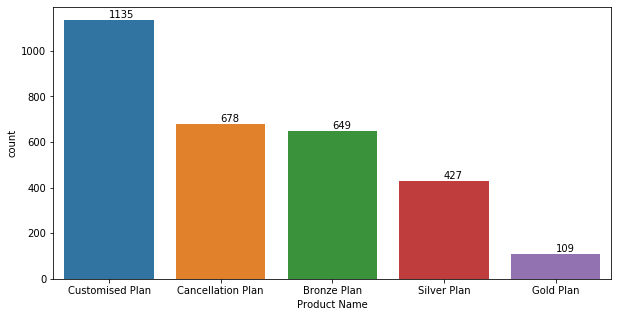

Percentage share:

Customised Plan      37.858572
Cancellation Plan    22.615077
Bronze Plan          21.647765
Silver Plan          14.242829
Gold Plan             3.635757
Name: Product Name, dtype: float64
---------------------------------------------------------------------------------------


Destination

The number of unique entries in the column Destination : 3

The entry with the highest frequency in Destination : ASIA



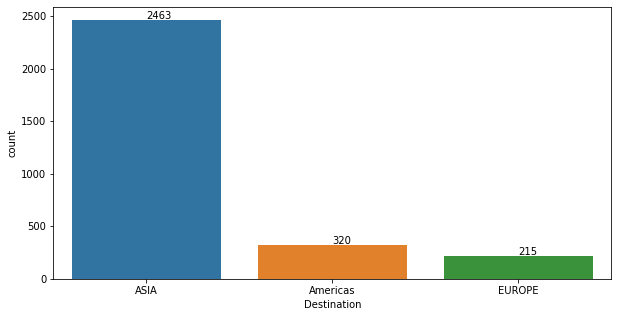

Percentage share:

ASIA        82.154770
Americas    10.673783
EUROPE       7.171448
Name: Destination, dtype: float64
---------------------------------------------------------------------------------------


In [19]:
data = claim_df.copy()
for j in categorical:
    print('\n\n\033[1m'+j+'\033[0m\n')
    print('The number of unique entries in the column %s : %d\n'%(j, data[j].nunique()))
    print('The entry with the highest frequency in %s : %s\n'%(j, data[j].mode()[0]))
    fig, axes = plt.subplots(ncols=1)
    fig.set_size_inches(10,5)
    sns.countplot(data[j])
    for p in axes.patches:
        axes.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+(p.get_width()/2), p.get_height()+10))
    plt.show()
    print('Percentage share:\n')
    print(data[j].value_counts(normalize=True)*100)
    print('---------------------------------------------------------------------------------------')

----------
**Multivariate Analysis**

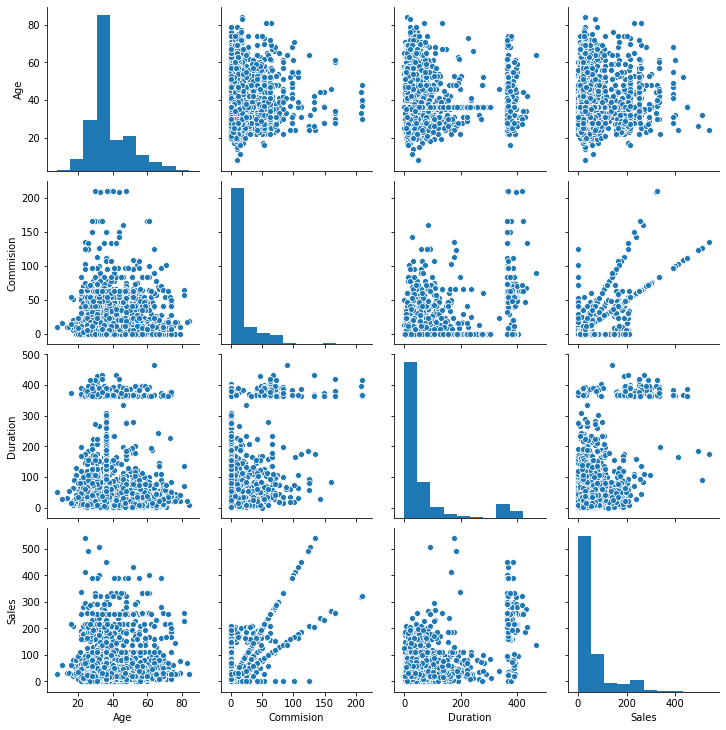

In [20]:
# Pairplot for continuous variable
sns.pairplot(claim_df[continuous])

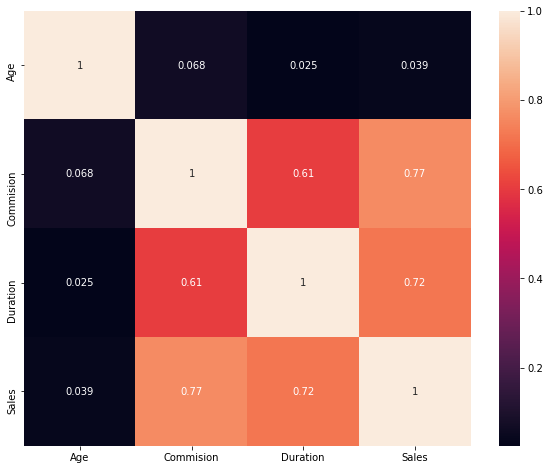

In [21]:
# Correlation coefficients and heat map for continuous variables
corr = claim_df[continuous].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)

-------
#### Outlier Treatment
Since there is a large amount of data in each of the continuous variables, we will treat ouliers before we proceed.

In [22]:
# Treating the outliers in teh data set
for feature in continuous: 
    lr,ur=remove_outlier(claim_df[feature])
    claim_df[feature]=np.where(claim_df[feature]>ur,ur,claim_df[feature])
    claim_df[feature]=np.where(claim_df[feature]<lr,lr,claim_df[feature])

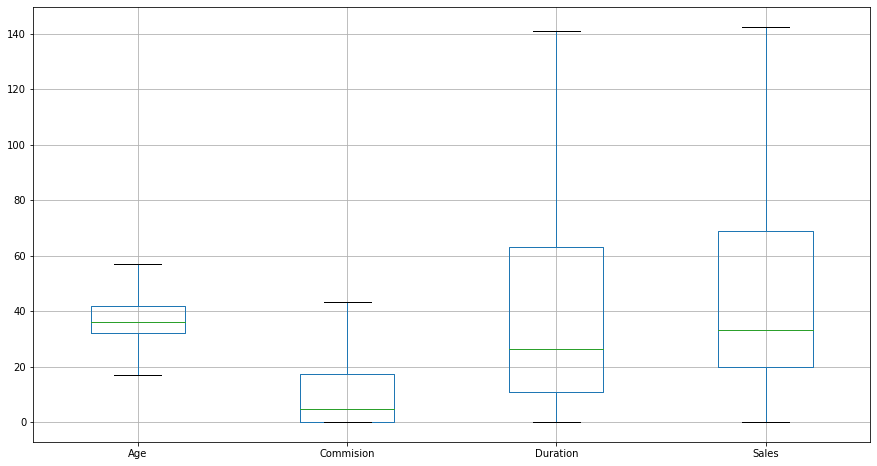

In [23]:
# Plotting the box plot to see if teh outliers still exist
plt.figure(figsize=(15,8))
claim_df.boxplot()

It can be observed that the putliers have been removed and the data is ready to be modeled.

### The Claimed variable is the dependent variable. Let us visualize this against other variables to get some interenting insights



Agency_Code



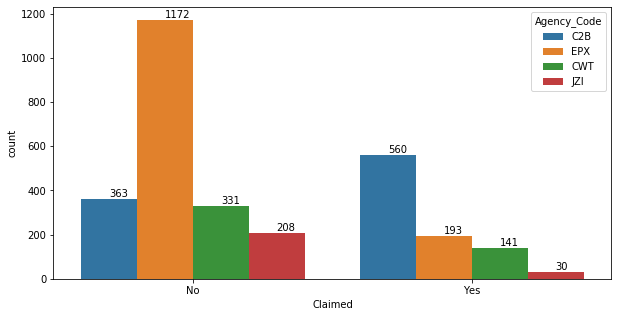

---------------------------------------------------------------------------------------


Type



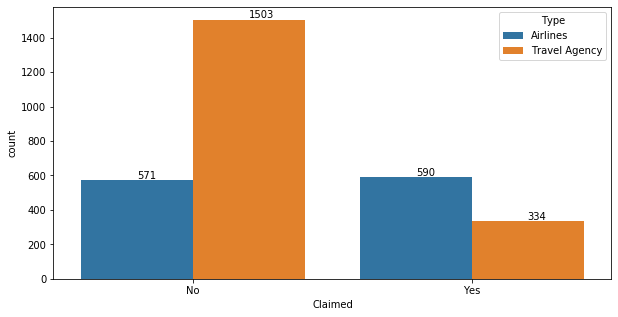

---------------------------------------------------------------------------------------


Channel



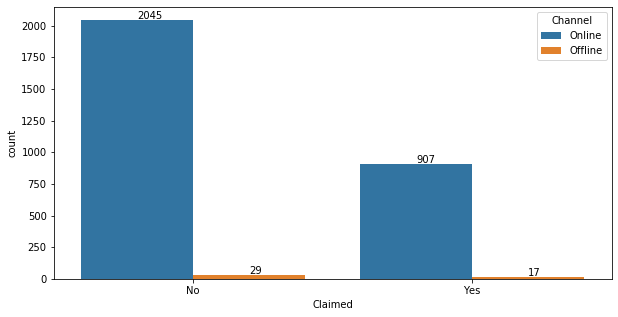

---------------------------------------------------------------------------------------


Product Name



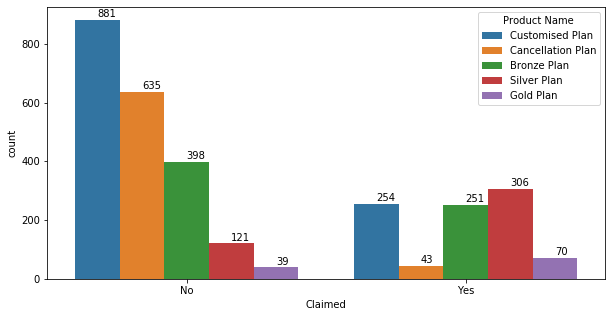

---------------------------------------------------------------------------------------


Destination



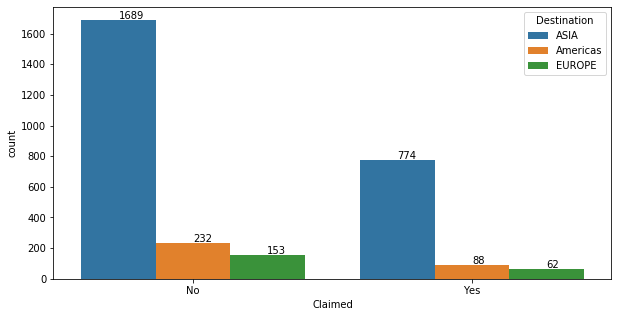

---------------------------------------------------------------------------------------


In [24]:
# The count plot for the categorical variables with Claimed as the slicing
data = claim_df.copy()
for i in categorical:
    if i != 'Claimed':
        print('\n\n\033[1m'+i+'\033[0m\n')
        fig, axes = plt.subplots(ncols=1)
        fig.set_size_inches(10,5)
        sns.countplot(data['Claimed'], hue=data[i])
        for p in axes.patches:
            axes.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+(p.get_width()/2), p.get_height()+10))
        plt.show()
        print('---------------------------------------------------------------------------------------')



Age



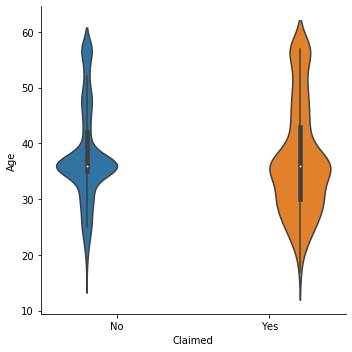

---------------------------------------------------------------------------------------


Commision



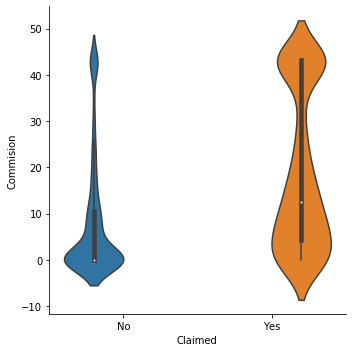

---------------------------------------------------------------------------------------


Duration



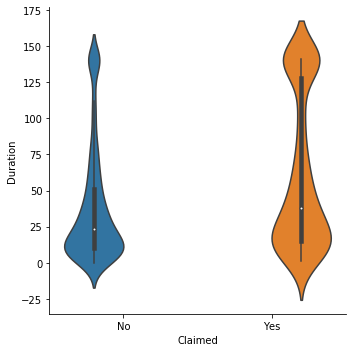

---------------------------------------------------------------------------------------


Sales



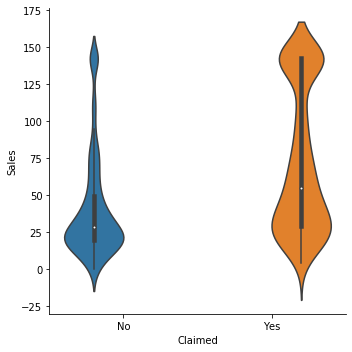

---------------------------------------------------------------------------------------


In [25]:
# The box plot for the categorical variables with Claimed as the slicing
data = claim_df.copy()
for i in continuous:
    print('\n\n\033[1m'+i+'\033[0m\n')
    sns.catplot(
        x='Claimed',
        y=i,
        hue='Claimed',
        data=data,
        kind='violin'
    );
    plt.show()
    print('---------------------------------------------------------------------------------------')

**Findings:**
- The data has 3000 (rows) entries and 10 (columns) variables
- The columns in the data are:
    - 'Age'
    - 'Agency_Code'
    - 'Type'
    - 'Claimed'
    - 'Commision' 
    - 'Channel'
    - 'Duration' 
    - 'Sales'
    - 'Product Name'
    - 'Destination'
- The variables Age and Duration are integer datatype (continuous), Commission and Sales are float datatype (continuous). The remaining are all object datatype (categorical). This is inline with what is observed from the head.
- There are no missing values in the data.
- The minimum value in Duration is -1. The duration of travel cannot be negative value. A 0 can still be taken as Not traveled but a negative value is not possible. We will proceed by droping this row.
- Similarly there is a very high value of 4580 days (approx 12 years). Since this is practically not possible, we will proceed by dropping this row.
- All the continuous variables are Right Skewed.
- All the continuous variables have approximately 10% of the data that are outliers.
- There are not many correlated variables and so we can proceed with the data as it is (without PCA).
-	From the plot of categorical data with the Claimed variable, the following can be inferred:
    -	Though EPX has a high market share, they have the highest not claimed. Whereas, CB2 has a lower market share compared to EPX, but still has a higher number of claims.
    -	The travel agency type insurance have higher possibility of not claimed that the airline type. Airline type has a higher chance of being claimed.
    -	When a plan is customized there is a high number of no claim. However the Silver plan has a greater claim compared to the other products.
    -	Since Asia is the most travelled location, the claims are also proportionally high. The similar case with other regions as well. So we can say that the destination of travel doesn’t play a very pivotal role in the claims.
-	From the plot of continuous data with the Claimed variable, the following can be inferred:
        -	The age group of 30’s have a high numbers of not claiming and not claiming. This is mainly because of the high number of observations present in that age group. However,  customers in the early 30’s and lesser have an unusual practice of claiming. The same is observed for late 30’s and early 40’s.
        -	For larger values of Sales, Duration and Commission, there is a sudden increase in the number of claims observed.

# ---------------------------------------------------------------------------------------------
### Question 2

Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network


#### Dependent Variable : Claimed
#### None of the columns prove to be useless. Hence we will proceed using the remaining columns as indepdendent variables

In [26]:
# To keep the original data untouched we will create a copy of it 
model_df = claim_df.copy()

Since the CART, Random Forest and ANN models cannot interpret the nominal codes we will have to convert them into numeric equivalents.

In [27]:
# Before we can proceed with spliting the data into tests and train sets we will have to first convert the nominal scaled categorical variables to numbers
for col in model_df.columns: 
    if model_df[col].dtype == 'object': 
        print('\n')
        print('\n\n\033[1m Column : %s\033[0m\n'%(col))
        print(pd.DataFrame(data= {'Value': pd.Categorical(model_df[col].unique()),
                                  'Code' : pd.Categorical(model_df[col].unique()).codes}))
        model_df[col] = pd.Categorical(model_df[col]).codes





 Column : Agency_Code

  Value  Code
0   C2B     0
1   EPX     2
2   CWT     1
3   JZI     3




 Column : Type

           Value  Code
0       Airlines     0
1  Travel Agency     1




 Column : Claimed

  Value  Code
0    No     0
1   Yes     1




 Column : Channel

     Value  Code
0   Online     1
1  Offline     0




 Column : Product Name

               Value  Code
0    Customised Plan     2
1  Cancellation Plan     1
2        Bronze Plan     0
3        Silver Plan     4
4          Gold Plan     3




 Column : Destination

      Value  Code
0      ASIA     0
1  Americas     1
2    EUROPE     2


The data are coded as per below:
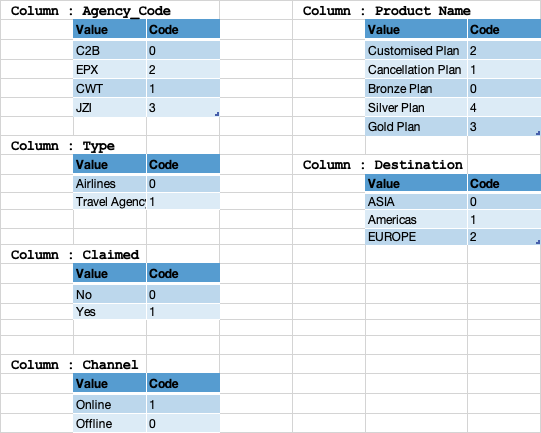

In [28]:
# To check if the data is all coded into integer type
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2998 non-null   float64
 1   Agency_Code   2998 non-null   int8   
 2   Type          2998 non-null   int8   
 3   Claimed       2998 non-null   int8   
 4   Commision     2998 non-null   float64
 5   Channel       2998 non-null   int8   
 6   Duration      2998 non-null   float64
 7   Sales         2998 non-null   float64
 8   Product Name  2998 non-null   int8   
 9   Destination   2998 non-null   int8   
dtypes: float64(4), int8(6)
memory usage: 134.7 KB


### Important:
        The Claimed data is the dependent variable.
        The rest are all independent variables.
        In Claimed variable, 1 is Claimed and 0 is Not Claimed.
As per business requirement it is important to know who will claim rather than who won't. Hence we will stick to the existing codes for Claimed variable.
                
## Spliting Data
#### Splitting the data into train and test data set

In [29]:
# First we will split the data into depedent and independent variables
X = model_df.drop("Claimed", axis=1)
y = model_df["Claimed"]

In [30]:
# Spliting data into train and test in the ratio 7:3
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)

In [31]:
# Checking the shape of the new split data
X_train.shape, X_test.shape, train_labels.shape, test_labels.shape

((2098, 9), (900, 9), (2098,), (900,))

In [32]:
# Let us ensure that the split of the dependent variable is in the same ratio of the original set
train_labels.value_counts(normalize=True), test_labels.value_counts(normalize=True)

(0    0.701144
 1    0.298856
 Name: Claimed, dtype: float64,
 0    0.67
 1    0.33
 Name: Claimed, dtype: float64)

The split for train and test is almost in the same ratio of the original data.
______

## CART Model

In [33]:
# To obtain the best possible hyper parameters we will run a grid search with a range of values
param_grid = {
    'criterion': ['gini'],
    'max_depth': [2, 3, 5, 10, 20, 30, 50], # Initially staring off with [20, 30, 50]
    'min_samples_leaf': [5, 10, 20, 30, 50, 100, 150], # Initially staring off with [50, 100, 150]]
    'min_samples_split': [50, 100, 150, 300, 450], # Initially staring off with [150, 300, 450]
}

# A decision tree estimator
cart = DecisionTreeClassifier(random_state=1)

# Grid search with the parameters and the cross validation as 10
grid_search = GridSearchCV(estimator = cart, param_grid = param_grid, cv = 10)

In [34]:
# Fitting the data on to our grid search
grid_search.fit(X_train,train_labels)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini'],
                         'max_depth': [2, 3, 5, 10, 20, 30, 50],
                         'min_samples_leaf': [5, 10, 20, 30, 50, 100, 150],
                         'min_samples_split': [50, 100, 150, 300, 450]})

In [35]:
# Amongst the entered values obtaining the best hyper paramerters 
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 20,
 'min_samples_split': 150}

On hitting the lower or upper limits in the values entered, we will go further down or up respectively.

Upon many trial we have arrived at the following hyper parameters:

            {'criterion': 'gini',
             'max_depth': 5,
             'min_samples_leaf': 20,
             'min_samples_split': 150}

In [36]:
# Obtaining the model estimator with the above best hyper parameters
best_cart = grid_search.best_estimator_

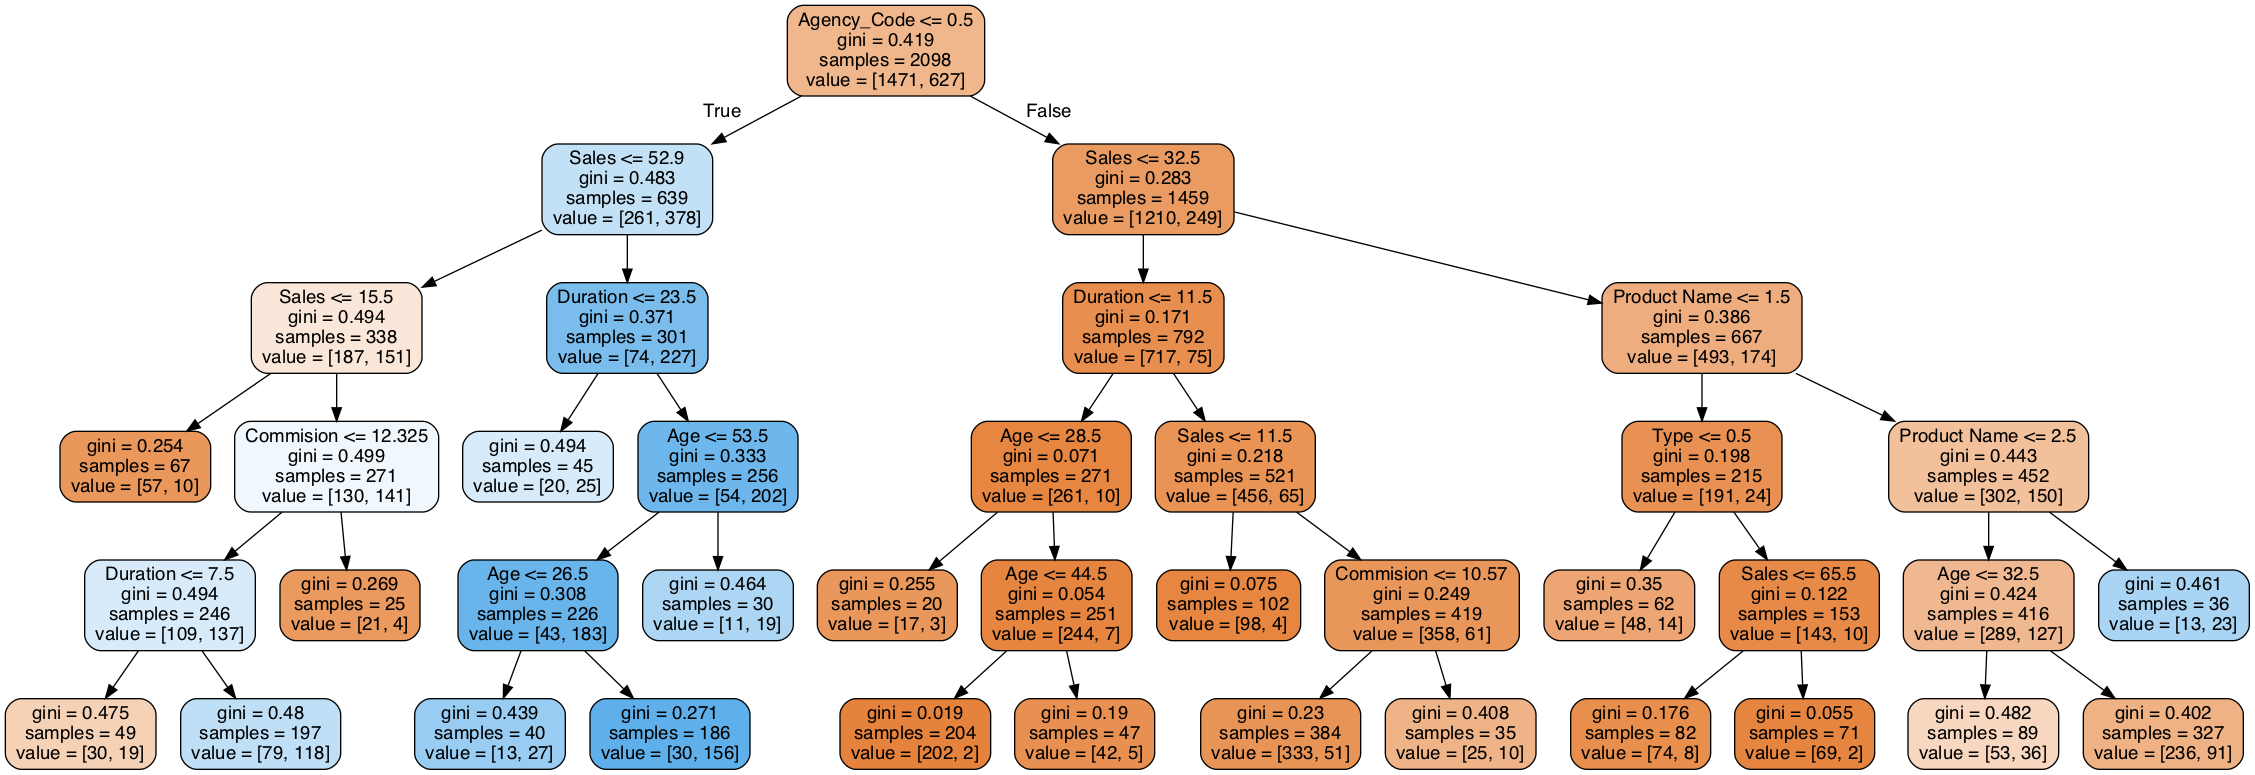

In [37]:
# Ploting the tree in line within the code:
dot_data = StringIO()
export_graphviz(best_cart, out_file=dot_data, filled=True, rounded=True, feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())

______
## Random Forest

In [38]:
# To obtain the best hyper parameters we will run grid search with a range of values
param_grid = {
    'max_depth': [5], # Retaining the parameter from the CART Model
    'max_features': [3, 4, 5], # Initially tried with [1, 2, 3, 4]
    'min_samples_leaf': [20], # Retaining the parameter from the CART Model
    'min_samples_split': [150], # Retaining the parameter from the CART Model
    'n_estimators': [90, 100, 150] # Initlially tried with [200, 300, 400]
}

# Creating an estimator for random forest
rfcl = RandomForestClassifier(random_state=1)

# Initializing grid search with cross validation of 10
grid_search = GridSearchCV(estimator = rfcl, verbose=1, param_grid = param_grid, cv = 5)

In [39]:
# Fitting the data on to our grid search
grid_search.fit(X_train, train_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   13.0s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [5], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [20], 'min_samples_split': [150],
                         'n_estimators': [90, 100, 150]},
             verbose=1)

In [40]:
# Viewing the best parameters
grid_search.best_params_

{'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 20,
 'min_samples_split': 150,
 'n_estimators': 100}

On hitting the lower or upper limits in the values entered, we will go further down or up respectively.

In [41]:
# Creating an estimator with the best hyper parameters from grid search
best_rf = grid_search.best_estimator_

-----
# Artificial Neural Network (ANN)

In [42]:
# Before er can proceed with ANN we need to scale the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

# We will then transform the test data based on the means of the training data
X_test_sc = sc.transform(X_test)

In [43]:
# To find the best hyper parameters we will perform grid search
# The below gives good resutls onthe train data but the values on test are quiet bad (not overfitted nut the recal drops considerably)
# param_grid = {
#     'hidden_layer_sizes': [100, 200, 300], # Initially tried with [300, 400, 500]
#     'max_iter': [100, 200], # Initially tried with [1000, 2000]
#     'solver': ['sgd','adam'],
#     'tol': [0.01, 0.001], # # Initially tried with [0.01, 0.001]
# }

param_grid = {
    'hidden_layer_sizes': [20, 50, 100], # Initially tried with [300, 400, 500]
    'max_iter': [10, 15, 20], # Initially tried with [1000, 2000]
    'solver': ['adam'],
    'tol': [0.01], # # Initially tried with [0.01, 0.001]
}

# Creating a estimator with random state = 1
anncl = MLPClassifier(random_state=1)

# Creating a classifier for grid search 
grid_search = GridSearchCV(estimator = anncl, param_grid = param_grid, cv = 10)

In [44]:
# Fitting the train data on to the grid search
grid_search.fit(X_train_sc, train_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=1),
             param_grid={'hidden_layer_sizes': [20, 50, 100],
                         'max_iter': [10, 15, 20], 'solver': ['adam'],
                         'tol': [0.01]})

In [45]:
# Viewing the best hyper parameters
grid_search.best_params_

{'hidden_layer_sizes': 50, 'max_iter': 20, 'solver': 'adam', 'tol': 0.01}

On hitting the lower or upper limits in the values entered, we will go further down or up respectively.

In [46]:
# Creating an estimator with best hyper parameters
best_ann = grid_search.best_estimator_

# ---------------------------------------------------------------------------------------------
### Question 3

Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

## Performance of CART Model
**Feature Importance**

In [47]:
# A very important feature of CART model is the feature importance. It gives us the list of most important to less important variables
pd.DataFrame(best_cart.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False)

,Imp
Agency_Code,0.573956
Sales,0.244626
Product Name,0.078409
Duration,0.038015
Commision,0.031535
Age,0.025179
Type,0.008282
Channel,0.000000
Destination,0.000000


In [48]:
# Prediction on the train and test data
X_train_cart_pred = best_cart.predict(X_train)
X_test_cart_pred = best_cart.predict(X_test)

**Confusion Matrix**

In [49]:
# Confusion matrix for train data
confusion_matrix(train_labels, X_train_cart_pred)

array([[1305,  166],
       [ 259,  368]])

In [50]:
# Confusion matrix for test data
confusion_matrix(test_labels, X_test_cart_pred)

array([[538,  65],
       [138, 159]])

**Classfication Report**

In [51]:
# Clasification report for the train data
print(classification_report(train_labels, X_train_cart_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1471
           1       0.69      0.59      0.63       627

    accuracy                           0.80      2098
   macro avg       0.76      0.74      0.75      2098
weighted avg       0.79      0.80      0.79      2098



In [52]:
# Obtaining the train metrics into variables
cart_metrics=classification_report(train_labels, X_train_cart_pred, output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_train_f1=round(df.loc["1"][2],2)
cart_train_recall=round(df.loc["1"][1],2)
cart_train_precision=round(df.loc["1"][0],2)
cart_train_acc=round(df.loc["accuracy"][2],2)

In [53]:
# Clasification report for the test data
print(classification_report(test_labels, X_test_cart_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       603
           1       0.71      0.54      0.61       297

    accuracy                           0.77       900
   macro avg       0.75      0.71      0.73       900
weighted avg       0.77      0.77      0.77       900



In [54]:
# Obtaining the test metrics into variables
cart_metrics=classification_report(test_labels, X_test_cart_pred, output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_test_f1=round(df.loc["1"][2],2)
cart_test_recall=round(df.loc["1"][1],2)
cart_test_precision=round(df.loc["1"][0],2)
cart_test_acc=round(df.loc["accuracy"][2],2)

**ROC**

AUC: 0.830


Text(0.5, 1.0, 'ROC for train data (CART Model)')

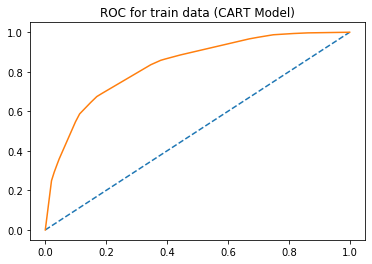

In [55]:
# For train data
probs = best_cart.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = round(roc_auc_score(train_labels, probs),2)
print('AUC: %.3f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr)
plt.title('ROC for train data (CART Model)')

AUC: 0.800


Text(0.5, 1.0, 'ROC for test data (CART Model)')

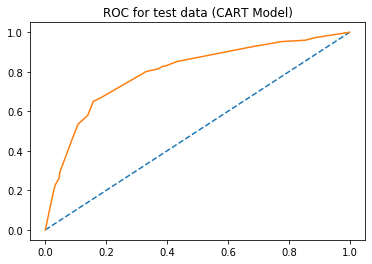

In [56]:
# For test data
probs = best_cart.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = round(roc_auc_score(test_labels, probs),2)
print('AUC: %.3f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, cart_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr)
plt.title('ROC for test data (CART Model)')

**Conclusion**

In [57]:
print('\n\n\033[1mCART (All parameters in %)\033[0m')
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART (Train)':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART (Test)':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1]},index=index)
cart_performance = round(data,2)*100
cart_performance



CART (All parameters in %)


,CART (Train),CART (Test)
Accuracy,80.0,77.0
AUC,83.0,80.0
Recall,59.0,54.0
Precision,69.0,71.0
F1 Score,63.0,61.0


From the classification report we can notice that 
- the model is not over fitted.
- the recall and the precision score is very low and can be improved further more

------
## Performance of Random Forest
**Feature Importance**

In [58]:
# A very important feature of CART model is the feature importance. It gives us the list of most important to less important variables
pd.DataFrame(best_rf.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False)

,Imp
Agency_Code,0.359942
Product Name,0.206549
Sales,0.182020
Commision,0.112921
Type,0.064260
Duration,0.046700
Age,0.021696
Destination,0.005550
Channel,0.000362


In [59]:
# Prediction for the train and test data
X_train_rf_pred = best_rf.predict(X_train)
X_test_rf_pred = best_rf.predict(X_test)

**Confusion Matrix**

In [60]:
# # Confusion matrix for train data
confusion_matrix(train_labels, X_train_rf_pred)

array([[1343,  128],
       [ 307,  320]])

In [61]:
# # Confusion matrix for test data
confusion_matrix(test_labels, X_test_rf_pred)

array([[545,  58],
       [156, 141]])

**Classification Report**

In [62]:
# Clasification report for the train data
print(classification_report(train_labels, X_train_rf_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1471
           1       0.71      0.51      0.60       627

    accuracy                           0.79      2098
   macro avg       0.76      0.71      0.73      2098
weighted avg       0.78      0.79      0.78      2098



In [63]:
# Obtaining the train metrics into variables
rf_metrics=classification_report(train_labels, X_train_rf_pred, output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_train_f1=round(df.loc["1"][2],2)
rf_train_recall=round(df.loc["1"][1],2)
rf_train_precision=round(df.loc["1"][0],2)
rf_train_acc=round(df.loc["accuracy"][2],2)

In [64]:
# Clasification report for the test data
print(classification_report(test_labels, X_test_rf_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       603
           1       0.71      0.47      0.57       297

    accuracy                           0.76       900
   macro avg       0.74      0.69      0.70       900
weighted avg       0.75      0.76      0.75       900



In [65]:
# Obtaining the test metrics into variables
rf_metrics=classification_report(test_labels, X_test_rf_pred, output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_f1=round(df.loc["1"][2],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_precision=round(df.loc["1"][0],2)
rf_test_acc=round(df.loc["accuracy"][2],2)

**ROC**

AUC: 0.830


Text(0.5, 1.0, 'ROC for train data (Random Forest Model)')

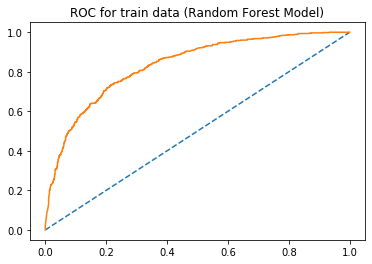

In [66]:
# For train data
probs = best_rf.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_train_auc = round(roc_auc_score(train_labels, probs),2)
print('AUC: %.3f' % rf_train_auc)
# calculate roc curve
rf_train_fpr, rf_train_tpr, rf_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(rf_train_fpr, rf_train_tpr)
plt.title('ROC for train data (Random Forest Model)')

AUC: 0.820


Text(0.5, 1.0, 'ROC for test data (Random Forest Model)')

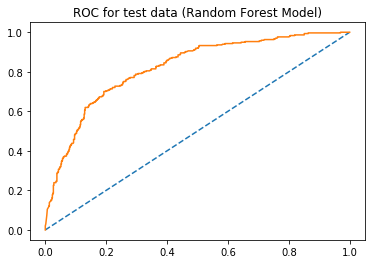

In [67]:
# For test data
probs = best_rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_test_auc = round(roc_auc_score(test_labels, probs),2)
print('AUC: %.3f' % rf_test_auc)
# calculate roc curve
rf_test_fpr, rf_test_tpr, rf_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(rf_test_fpr, rf_test_tpr)
plt.title('ROC for test data (Random Forest Model)')

**Conclusion**

In [68]:
print('\n\n\033[1mRandom Forest (All parameters in %)\033[0m')
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'Random Forest (Train)':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest (Test)':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1]},index=index)
rf_performance = round(data,2)*100
rf_performance



Random Forest (All parameters in %)


,Random Forest (Train),Random Forest (Test)
Accuracy,79.0,76.0
AUC,83.0,82.0
Recall,51.0,47.0
Precision,71.0,71.0
F1 Score,60.0,57.0


From the classification report we can notice that 
- the model is not over fitted.
- the recall score is very low and can be improved further more
- Precision is quite reasonable (not the best though).

------
## Performance of ANN
**ANN is one of the most powerful models however one very important draw back is that we don't get a feature importance in this. This is a black box algorithm as we are realy not sure of what exactly happens and so we don't get a feature importance. If this is made available then it has a potential to replace all other models.**

In [69]:
# Prediction on the train and test data
X_train_ann_pred = best_ann.predict(X_train)
X_test_ann_pred = best_ann.predict(X_test)

**Confusion Matrix**

In [70]:
# Confusion matrix for train data
confusion_matrix(train_labels, X_train_ann_pred)

array([[1162,  309],
       [ 298,  329]])

In [71]:
# Confusion matrix for test data
confusion_matrix(test_labels, X_test_ann_pred)

array([[481, 122],
       [154, 143]])

**Classfication Report**

In [72]:
# Clasification report for the train data
print(classification_report(train_labels, X_train_ann_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1471
           1       0.52      0.52      0.52       627

    accuracy                           0.71      2098
   macro avg       0.66      0.66      0.66      2098
weighted avg       0.71      0.71      0.71      2098



In [73]:
# Obtaining the train metrics into variables
ann_metrics=classification_report(train_labels, X_train_ann_pred, output_dict=True)
df=pd.DataFrame(ann_metrics).transpose()
ann_train_f1=round(df.loc["1"][2],2)
ann_train_recall=round(df.loc["1"][1],2)
ann_train_precision=round(df.loc["1"][0],2)
ann_train_acc=round(df.loc["accuracy"][2],2)

In [74]:
# Clasification report for the test data
print(classification_report(test_labels, X_test_cart_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       603
           1       0.71      0.54      0.61       297

    accuracy                           0.77       900
   macro avg       0.75      0.71      0.73       900
weighted avg       0.77      0.77      0.77       900



In [75]:
# Obtaining the test metrics into variables
ann_metrics=classification_report(test_labels, X_test_ann_pred, output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
ann_test_f1=round(df.loc["1"][2],2)
ann_test_recall=round(df.loc["1"][1],2)
ann_test_precision=round(df.loc["1"][0],2)
ann_test_acc=round(df.loc["accuracy"][2],2)

**ROC**

AUC: 0.710


Text(0.5, 1.0, 'ROC for train data (Artificial Neural Network Model)')

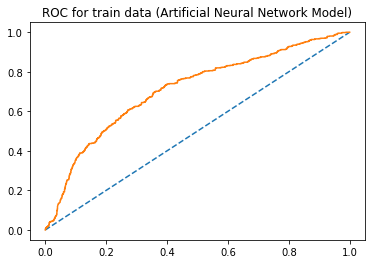

In [76]:
# For train data
probs = best_ann.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ann_train_auc = round(roc_auc_score(train_labels, probs),2)
print('AUC: %.3f' % ann_train_auc)
# calculate roc curve
ann_train_fpr, ann_train_tpr, ann_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(ann_train_fpr, ann_train_tpr)
plt.title('ROC for train data (Artificial Neural Network Model)')

AUC: 0.690


Text(0.5, 1.0, 'ROC for test data (Artificial Neural Network Model)')

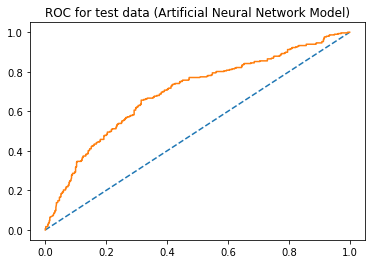

In [77]:
# For test data
probs = best_ann.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ann_test_auc = round(roc_auc_score(test_labels, probs),2)
print('AUC: %.3f' % ann_test_auc)
# calculate roc curve
ann_test_fpr, ann_test_tpr, ann_test_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(ann_test_fpr, ann_test_tpr)
plt.title('ROC for test data (Artificial Neural Network Model)')

**Conclusion**

In [78]:
print('\n\n\033[1mArtificial Neural Network (All parameters in %)\033[0m')
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'Artificial Neural Network (Train)':[ann_train_acc,ann_train_auc,ann_train_recall,ann_train_precision,ann_train_f1],
        'Artificial Neural Network (Test)':[ann_test_acc,ann_test_auc,ann_test_recall,ann_test_precision,ann_test_f1]},index=index)
ann_performance = round(data,2)*100
ann_performance



Artificial Neural Network (All parameters in %)


,Artificial Neural Network (Train),Artificial Neural Network (Test)
Accuracy,71.0,77.0
AUC,71.0,69.0
Recall,52.0,54.0
Precision,52.0,71.0
F1 Score,52.0,61.0


From the classification report we can notice that 
- the model is not over fitted.
- the precision score is very low and can be improved further more
- the recall score has improved quite a bit

# ---------------------------------------------------------------------------------------------
### Question 4

Final Model: Compare all the model and write an inference which model is best/optimized.

In [79]:
# We will consolidate all the model metrics
consolidate_models = pd.concat([cart_performance, rf_performance, ann_performance], axis=1)
consolidate_models

,CART (Train),CART (Test),Random Forest (Train),Random Forest (Test),Artificial Neural Network (Train),Artificial Neural Network (Test)
Accuracy,80.0,77.0,79.0,76.0,71.0,77.0
AUC,83.0,80.0,83.0,82.0,71.0,69.0
Recall,59.0,54.0,51.0,47.0,52.0,54.0
Precision,69.0,71.0,71.0,71.0,52.0,71.0
F1 Score,63.0,61.0,60.0,57.0,52.0,61.0


In [80]:
# For ease of analysing the metrics let us split the test and train into separate data frames
consolidate_models_train = consolidate_models[['CART (Train)', 'Random Forest (Train)', 'Artificial Neural Network (Train)']]
consolidate_models_train.style.highlight_max(color = 'lightgreen', axis = 1)

,CART (Train),Random Forest (Train),Artificial Neural Network (Train)
Accuracy,80.000000,79.000000,71.000000
AUC,83.000000,83.000000,71.000000
Recall,59.000000,51.000000,52.000000
Precision,69.000000,71.000000,52.000000
F1 Score,63.000000,60.000000,52.000000


In [81]:
consolidate_models_test = consolidate_models[['CART (Test)', 'Random Forest (Test)', 'Artificial Neural Network (Test)']]
consolidate_models_test.style.highlight_max(color = 'lightgreen', axis = 1)

,CART (Test),Random Forest (Test),Artificial Neural Network (Test)
Accuracy,77.000000,76.000000,77.000000
AUC,80.000000,82.000000,69.000000
Recall,54.000000,47.000000,54.000000
Precision,71.000000,71.000000,71.000000
F1 Score,61.000000,57.000000,61.000000


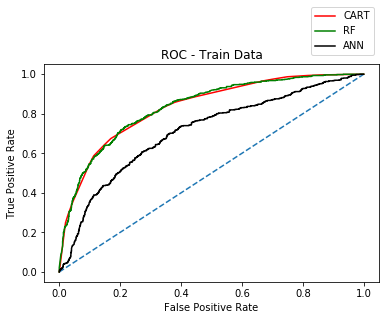

In [82]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(ann_train_fpr,ann_train_tpr,color='black',label="ANN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Train Data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

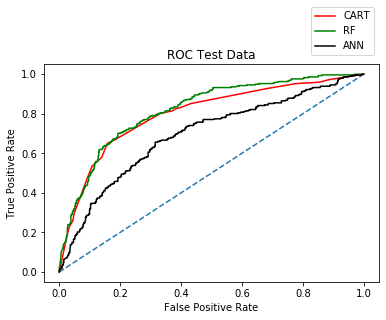

In [83]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(ann_test_fpr,ann_test_tpr,color='black',label="ANN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Test Data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

From the above tables, from the performance on train data we can clearly see that the CART model has performed well compared to the other two.

From ROC we can see the area under the curve is more for Random forest. However, the recall rate in the CART model is high and that is the desirable character int his case.

All the three models performed almost equally well on the test data but we can notice that the CART model has performed well in train and test data. Hence, we will proceed with CART model for the classification prediction in this case.

# ---------------------------------------------------------------------------------------------
### Question 5

Inference: Based on the whole Analysis, what are the business insights and recommendations

**Recommendations:**
-	There is an exceptionally large chunk of customers in the their mid/late 30’s. It would be advisable if the company normalized this a little to have a balanced risk portfolio. This can be executed by increasing the commission for agents for the other age groups.
-	There is a sudden spike in the duration of travel at 350+ days. This will skew the portfolio a little. This increases the probability of a claim .
-	From feature importance, we have analysed that Agent plays a very important role in the prediction as well. Keeping this in mind. We can say that EPX agent has large number of customers that do not claim while so the company can relax around with EPX. On the other hand,C2B agent the highest number of customers who have claimed. So company needs to be watchful of C2B agent.
-	The next important  feature is Product. The company can encourage more customized plans (provided the customization is done calculatedly as it is done now) as there are a large number of customers who don’t claim if they took a Customized plan. Similarly, the company needs to look into Silver Plan as it has the highest number of claims.
-	For 100 policies, using our prediction tool the company will be able to predict if a policy will be claimed or no accurately for 80 policies. This way there is only 20% uncertainty/risk (based on accuracy).
-	If we run new customers through our model and target on writing 100 customers for whom the model predicts that they will not claim. Then we can be sure that 80 of them will surely not claim. Whereas in earlier case we would have to assume that 70 of them will not claim (based on the precision for not claimed).
-	By historical means if we found out that 100 customers will claim then we would set aside the amount to pay these 100 customers as claim reserve. However if the model predicts that 100 customers will claim we can be sure that only 54 of them will claim. The remaining amount (46 customer’s claim money) can be invested elsewhere to make profits as claims reserve is considered to be a stagnated fund in the insurance industry.